## VRFT with measurement noise (no instrumental variables)

In [1]:
# Copyright [2020] [Alessio Russo - alessior@kth.se]  
# This file is part of PythonVRFT.
# PythonVRFT is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, version 3 of the License.
# PythonVRFT is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
# You should have received a copy of the GNU General Public License
# along with PythonVRFT.  If not, see <http://www.gnu.org/licenses/>.
#
# Code author: [Alessio Russo - alessior@kth.se]
# Last update: 08th January 2020, by alessior@kth.se
#

# Example 2
# ------------
# In this example we see how to apply VRFT to a simple SISO model
# with colored measurement noise (no instrumental variables)
# Input data is generated using random normal noise
#

### Load libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scipysig
from vrft import *

### System, Reference Model and Control law

In [3]:
# System
dt = 1e-2
num = [0.5]
den = [1, -0.9]
sys = ExtendedTF(num, den, dt=dt)

# Reference Model
refModel = ExtendedTF([0.6], [1, -0.4], dt=dt)

# Control law
control = [ExtendedTF([1], [1, -1], dt=dt),
        ExtendedTF([1, 0], [1, -1], dt=dt)]


### Generate signals

In [4]:
def generateNoise(t):
    # Generate colored noise
    omega = 2*np.pi*100
    xi = 0.9
    dt = t[1] - t[0]
    noise =  np.random.normal(0,0.1,t.size)
    tf = scipysig.TransferFunction([10*omega**2], [1, 2*xi*omega, omega**2])
    # Second order system
    _, yn, _ = scipysig.lsim(tf, noise, t)
    return yn

# Generate input siganl
t_start = 0
t_end = 10
t = np.arange(t_start, t_end, dt)
u = np.random.normal(size = t.size)

# Open loop experiment
t, y = scipysig.dlsim(sys, u, t)
y = y.flatten() + generateNoise(t)

# Save data into an IDDATA Object with 0 initial condition
# Length of the initial condition depends on the reference model
data = iddata(y, u, dt, [0])

### VRFT

In [5]:
# VRFT Pre-filter
prefilter = refModel * (1 -  refModel)

# VRFT method
theta, r, loss, C = compute_vrft(data, refModel, control, prefilter)

#Obtained controller
print("Loss: {}\nTheta: {}\nController: {}".format(loss, theta, C))

Loss: 0.3207682187262347
Theta: [-0.2482335   0.28201084]
Controller: ExtendedTF(
array([ 0.28201084, -0.2482335 ]),
array([ 1., -1.]),
dt: 0.01
)


### Verify performance

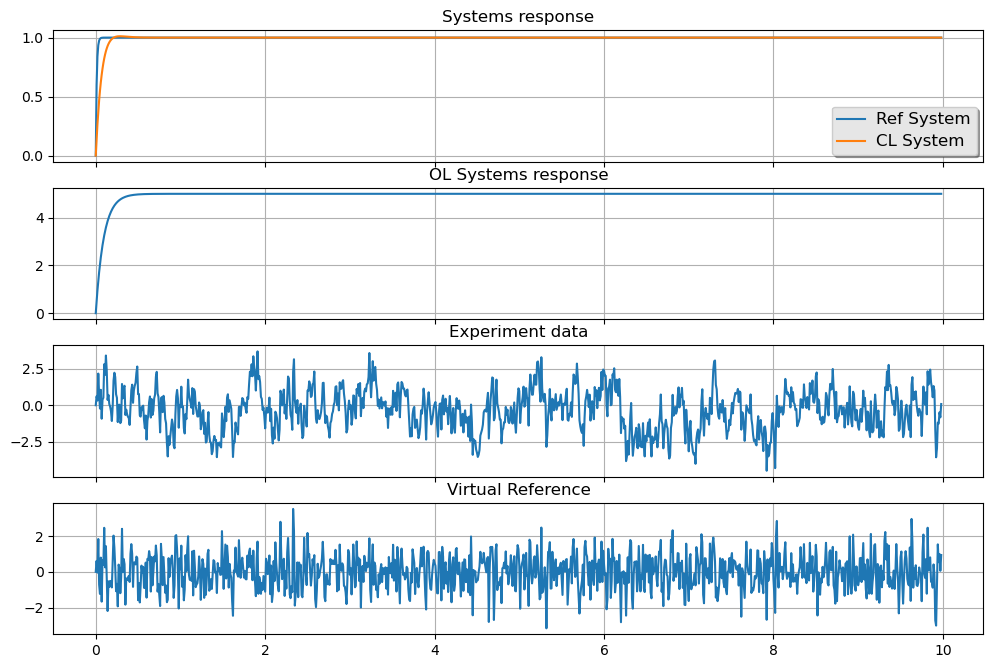

In [6]:
# Closed loop system
closed_loop = (C * sys).feedback()

t = t[:len(r)]
u = np.ones(len(t))

_, yr = scipysig.dlsim(refModel, u, t)
_, yc = scipysig.dlsim(closed_loop, u, t)
_, ys = scipysig.dlsim(sys, u, t)

yr = np.array(yr).flatten()
ys = np.array(ys).flatten()
yc = np.array(yc).flatten()
fig, ax = plt.subplots(4, sharex=True, figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
ax[0].plot(t, yr,label='Reference System')
ax[0].plot(t, yc, label='CL System')
ax[0].set_title('Systems response')
ax[0].grid(True)
ax[1].plot(t, ys, label='OL System')
ax[1].set_title('OL Systems response')
ax[1].grid(True)
ax[2].plot(t, y[:len(r)])
ax[2].grid(True)
ax[2].set_title('Experiment data')
ax[3].plot(t, r)
ax[3].grid(True)
ax[3].set_title('Virtual Reference')

# Now add the legend with some customizations.
legend = ax[0].legend(loc='lower right', shadow=True)

# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.show()
